In [4]:
from GG_mthesis import *
%matplotlib inline

sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set(font_scale=1.2)

from netCDF4 import Dataset

#============================================================================#
#This is an example script showing how to use, and save, the WHOSE jet detection
#alogorithm. The example uses AVISO gridded altimetry (ADT) in the north Pacific region
#with a focus on the Kuroshio current. The example ADT file can be downloaded 
# from:
# https://www.dropbox.com/s/p2ygo43odrsyjwx/adt_Kuroshio_2010.nc?dl=0
# 
# You'll need NetCDF4 to read the netcdf files
# http://unidata.github.io/netcdf4-python/
#============================================================================#


In [6]:
os.getcwd()

'C:\\Users\\gian_\\repos\\mthesis_gianlucca'

In [5]:
#=========================#
# WAVELET PARAMETERS
#=========================#
N_DECOMP_LEVELS = 4
confidence_param = 0.9

#============================#
#Set the gradient threshold
grad_thres = 0.0025 #(units: m/km - reported in text as m/100km)
#============================#

#Start year and end year 
START_YEAR = 2010
END_YEAR   = 2011

In [7]:
#==================================================#
#Input and output paths of the files
base_sla_path = 'data/AVISO/'
base_output_path = base_sla_path

adt_file_stem = 'adt_Kuroshio_'
output_file_stem = 'jet_detection_Kuroshio_'
#==================================================#

In [8]:
#==========================#
#Here we instantiate the
#wavelet jet detection class
#==========================#
wavelet_jet_detector = Wavelet_Jet_Detection.Jet_Detector(N_DECOMP_LEVELS,confidence_param,wavelet_basis='haar',
                       grad_thresh=grad_thres)
#==========================#

In [16]:
#==========================#                    
#some counters
time_counter = 0
start_lon = 0

for i_year in range(START_YEAR,END_YEAR):
    
    #Load input data
    dataset_adt = Dataset(base_sla_path+adt_file_stem + str(i_year) + '.nc','r')
    adt         = dataset_adt.variables['adt'][:,:,:]
    time        = dataset_adt.variables['time'][:]
    lat_adt     = dataset_adt.variables['latitude'][:]
    lon_adt     = dataset_adt.variables['longitude'][:]
    
    
    nT    = time.size   
    n_lon = lon_adt.size
    n_lat = lat_adt.size
    jet_histogram = np.zeros([n_lat,n_lon],dtype='u4')
    jet_locations = np.zeros([nT,n_lat,n_lon],dtype='u4')

#============================#
    #Set up the output file
    #============================#
    print('writing file to: ', base_output_path+output_file_stem + str(i_year)+'.nc')
    dataset_out        = Dataset(base_output_path+output_file_stem + str(i_year)+'.nc',
                                'w',clobber=True, format='NETCDF4')
                                
                                
    dataset_out.createDimension('time', None)
    var_time = dataset_out.createVariable('time', 'f8', ['time'])
    dataset_out.createDimension('lat', n_lat)
    dataset_out.createDimension('lon', n_lon)
    var_lat = dataset_out.createVariable('lat', 'f8', ['lat'])
    var_lon = dataset_out.createVariable('lon', 'f8', ['lon'])
    var_time[:] = time

    var_lat[:] = lat_adt
    var_lon[:] = lon_adt
    var_hist      = dataset_out.createVariable('jet_loc_hist', 'f8', ['lat','lon'])
    var_locations = dataset_out.createVariable('jet_locations', 'f8', ['time','lat','lon'])
    #============================#
    
    for iT in range(0,nT):
        print("time step: ", iT, " of ", nT)
        for i_lon in range(start_lon,n_lon):
            adt_slice = adt[iT,:,i_lon]
            adt_slice[adt_slice.mask] = np.nan            
            #================================================================#
            #Here's where the magic happens
            #For each meridional transect, and at each time step, we apply the 
            #methodology.
            #================================================================#
            lon_positions, lat_positions = wavelet_jet_detector.detect_jets(lon_adt[i_lon]*np.ones(n_lat), lat_adt,adt_slice,only_eastward=True)
            
            
            for i_jet in range(0,len(lat_positions)):
                index_y = np.nonzero(lat_adt>=lat_positions[i_jet])[0][0]     
                jet_histogram[index_y,i_lon] = jet_histogram[index_y,i_lon]+1
                jet_locations[iT,index_y,i_lon] = 1
    
    #Write the jet locations to file 
    var_locations[0:nT,:,:] =  jet_locations 
    time_counter = time_counter+nT    
    
        
    dataset_adt.close()
    
    
    #Write the jet histogram to file 
    var_hist[:,:] = jet_histogram/float(time_counter)
    dataset_out.close()  

topo_mask = np.isnan(adt[0,:,:])
jet_histogram_masked = np.ma.masked_where(topo_mask, jet_histogram)

writing file to:  data/AVISO/jet_detection_Kuroshio_2010.nc
time step:  0  of  365
c:\users\gian_\repos\mthesis_gianlucca\src\GG_mthesis\Wavelet_Jet_Detection.py:434: RuntimeWarning: invalid value encountered in double_scalars
  slope = (end_value-start_value)/(end_y-start_y)
time step:  1  of  365
time step:  2  of  365
time step:  3  of  365
time step:  4  of  365
time step:  5  of  365
time step:  6  of  365
time step:  7  of  365
time step:  8  of  365
time step:  9  of  365
time step:  10  of  365
time step:  11  of  365
time step:  12  of  365
time step:  13  of  365
time step:  14  of  365
time step:  15  of  365
time step:  16  of  365
time step:  17  of  365
time step:  18  of  365
time step:  19  of  365
time step:  20  of  365
time step:  21  of  365
time step:  22  of  365
time step:  23  of  365
time step:  24  of  365
time step:  25  of  365
time step:  26  of  365
time step:  27  of  365
time step:  28  of  365
time step:  29  of  365
time step:  30  of  365
time step:  

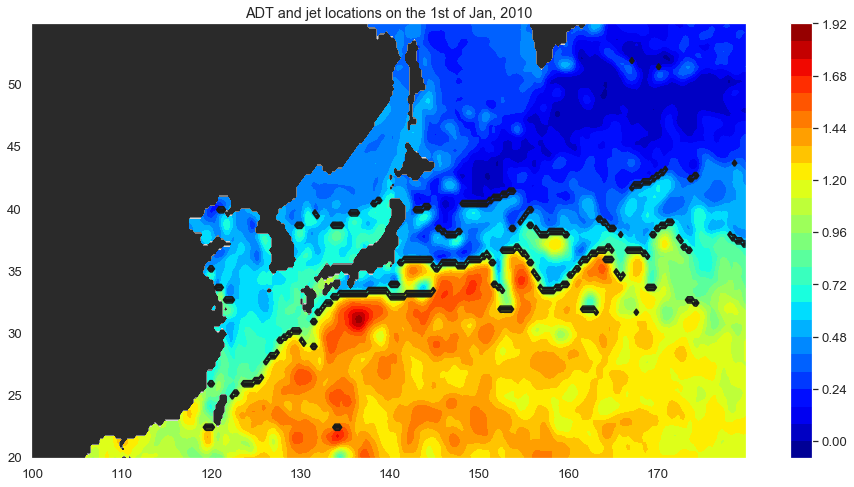

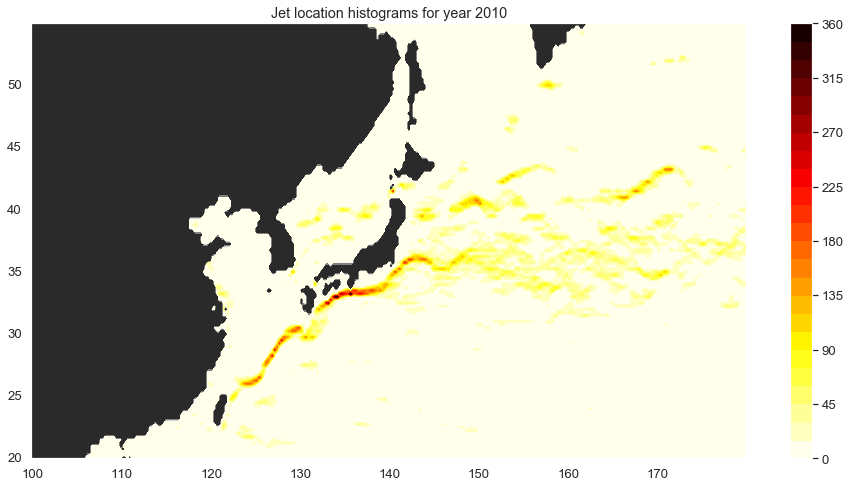

In [20]:
#Let's make some plots
fig  = plt.figure(1, figsize=(16,8))
ax   = fig.add_subplot(1,1,1)
ax.contourf(lon_adt,lat_adt,jet_histogram_masked.mask,2,cmap=plt.cm.gray_r)
cs = ax.contourf(lon_adt,lat_adt,adt[0,:,:],25,cmap=plt.cm.jet)
fig.colorbar(cs)
ax.contour(lon_adt,lat_adt,jet_locations[0,:,:],2,colors='k')
ax.set_title('ADT and jet locations on the 1st of Jan, 2010')


fig  = plt.figure(2, figsize=(16,8))
ax   = fig.add_subplot(1,1,1)
ax.contourf(lon_adt,lat_adt,jet_histogram_masked.mask,2,cmap=plt.cm.gray_r)

cs = ax.contourf(lon_adt,lat_adt,jet_histogram_masked,25,cmap=plt.cm.hot_r)
fig.colorbar(cs)
ax.set_title('Jet location histograms for year 2010')
plt.show()
